### 6.2.1 互相关运算


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


C:\Users\25466\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\25466\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0]-h+1, X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w]*K).sum()
    return Y


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)


tensor([[19., 25.],
        [37., 43.]])

### 6.2.2 卷积层


In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias


### 6.2.3 图像中目标的边缘检测


In [16]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X


tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [17]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y


tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

### 6.2.4 学习卷积核


In [26]:
# 构造一个二维卷积层， 它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat-Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if(i+1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')


epoch 2, loss 1.068
epoch 4, loss 0.185
epoch 6, loss 0.034
epoch 8, loss 0.007
epoch 10, loss 0.002


In [27]:
conv2d.weight.data.reshape((1, 2))


tensor([[ 0.9920, -0.9974]])

### 6.3.1 填充


In [28]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数


def comp_conv2d(conv2d, X):
    # 这里(1,1)表示批量大小和通道数都是1
    X = X.reshape((1, 1)+X.shape)
    Y = conv2d(X)
    # 省略前两个维度: 批量大小和通道
    return Y.reshape(Y.shape[2:])


# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape


torch.Size([8, 8])

### 6.4.1 多输入通道


In [33]:
import torch
from d2l import torch as d2l


def corr2d_multi_in(X, K):
    # 先遍历"X"和"K"的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))


X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)


tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2 多输出通道


In [34]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输⼊“X”执⾏互相关运算。
    # 最后将所有结果都叠加在⼀起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)


In [35]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape


torch.Size([3, 2, 2, 2])

In [36]:
corr2d_multi_in_out(X, K)


tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 6.4.3 1x1 卷积层


In [47]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h*w))
    print(X)
    K = K.reshape((c_o, c_i))
    print(K)
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)  # 2*3 x 3*9 = 2*9
    return Y.reshape((c_o, h, w))


In [48]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6


tensor([[ 0.4995, -2.1972, -0.4441,  0.4625, -2.1499,  1.1449, -0.4287, -1.3286,
         -0.9873],
        [-0.3155, -1.6703, -1.1437,  0.5128,  0.8524, -1.8592, -0.1024,  1.2786,
         -1.0076],
        [ 0.2985,  0.5957, -1.3355,  0.7930,  0.5238, -2.7677,  0.9142, -1.6611,
         -1.5898]])
tensor([[-0.0932, -0.9415, -0.1644],
        [-0.2662,  0.2142, -0.9631]])


### 6.5.1 最大汇聚层和平均汇聚层


In [51]:
import torch
from torch import nn
from d2l import torch as d2l


In [52]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i+p_h, j:j+p_w].max()
            elif mode == "avg":
                Y[i, j] = X[i:i+p_h, j:j+p_w].avg()
    return Y


In [53]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))


tensor([[4., 5.],
        [7., 8.]])

### 6.6 卷积神经网络


In [77]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10)
)


In [78]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)


Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [79]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)


In [80]:
def evalute_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [81]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if(type(m) == nn.Linear or type(m) == nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # net.parameters()获取模型需要优化的参数
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=[
                            'train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train() # 将模型设置为训练模式
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0]) # d2l.accuracy(y_hat, y) 返回预测正确的个数
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if(i+1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                             (train_l, train_acc, None)) # 每个epoch采样5次
        test_acc = evalute_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(
        f'loss {train_l:.3f}, train_acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(
        f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')


loss 0.319, train_acc 0.878, test acc 0.856
22694.3 examples/sec on cuda:0


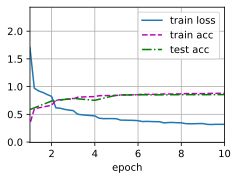

In [82]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())